<a href="https://colab.research.google.com/github/FelipeMYoshi/python_CUDA/blob/main/Projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#   Algoritmo   : Regressão Linear com e sem GPU
#   Disciplina  : Projeto Integrador IV-A
#   Descrição   : Detecção de doenças com base em sintomas
#   Estudantes  : Lucas XXXXXXXXX
#                 Felipe Martins Yoshimoto 
#                 Guilherme Colherinhas de Oliveira

In [ ]:
import seaborn as sb
import pandas as pd
import numpy as np
import time
import cudf
import cuml
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split as TTS
from sklearn.linear_model import LinearRegression as LR
from cuml.linear_model import LinearRegression as LR_GPU
from cuml.preprocessing import train_test_split as TTS_GPU
from cuml.cluster import KMeans as KMeans_GPU
import matplotlib.pyplot as pp

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Regressão linear - CPU

Ta = time.time_ns()
df_cpuRL = pd.read_csv('/content/drive/My Drive/BDIA-PUCGO/Projeto_Integrador_4A/Netflix-BDIA-FINAL.csv', 
                       sep=';', encoding='utf-8', names=['CODIGO','ANO','PONTOS','CLASSIFICACAO'])
X_cpuRL = np.array(df_cpuRL['ANO']).reshape(-1, 1)
Y_cpuRL = np.array(df_cpuRL['PONTOS'])
X_treino_cpuRL, X_teste_cpuRL, Y_treino_cpuRL, Y_teste_cpuRL = TTS(X_cpuRL, Y_cpuRL, train_size=0.75, random_state=42)
Tb = time.time_ns()

Taa = time.time_ns()
modelo_cpuRL = LR()
modelo_cpuRL.fit(X_treino_cpuRL, Y_treino_cpuRL)
Y_previsto_cpuRL = modelo_cpuRL.predict(X_teste_cpuRL)
Tbb = time.time_ns()

Tempo1 = Tb-Ta
Tempo2 = Tbb-Taa
print('======= RESULTADOS =======')
print(' ==> Tempo para ajuste dos dados CPU = ', Tempo1/1000000, 'ms')
print(' ==> Tempo para predição da Regressão Linear CPU = ', Tempo2/1000000, 'ms')
print('')
print('======= GRAFICO =======')


fig, ax = pp.subplots()
ax.plot(X_cpuRL, Y_cpuRL, linewidth=0, marker="x")
low_x, high_x = ax.get_xlim()
low_y, high_y = ax.get_ylim()
low = max(low_x, low_y)
high = min(high_x, high_y)
ax.plot(X_teste_cpuRL, Y_previsto_cpuRL, ls="-", c=".1", alpha=0.99)
ax.set_xlabel("Ano de produção", fontweight="bold")
ax.set_ylabel("Pontuação (Usuários)", fontweight="bold")



NameError: ignored

======= RESULTADOS =======
 ==> Tempo para ajuste dos dados GPU =  15.123765 ms
 ==> Tempo para predição da Regressão Linear GPU =  4.18474 ms

======= GRAFICO =======


/usr/local/lib/python3.7/site-packages/cuml/internals/api_decorators.py:409: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  return func(*args, **kwargs)


Text(0, 0.5, 'Pontuação (Usuários)')

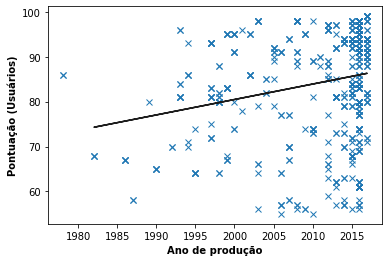

In [ ]:
# Regressão linear - GPU

TaRL = time.time_ns()
df_gpuRL = cudf.read_csv('/content/drive/My Drive/BDIA-PUCGO/Projeto_Integrador_4A/Netflix-BDIA-FINAL.csv', sep=';', 
                         low_memory=False, encoding='utf-8', names=['CODIGO','ANO','PONTOS','CLASSIFICACAO'], dtype=float)
X_gpuRL = cudf.DataFrame()
Y_gpuRL = cudf.DataFrame()
X_gpuRL['ANO'] = df_gpuRL['ANO']
Y_gpuRL['PONTOS'] = df_gpuRL['PONTOS']
X_treino_gpuRL, X_teste_gpuRL, Y_treino_gpuRL, Y_teste_gpuRL = TTS_GPU(X_gpuRL['ANO'], Y_gpuRL['PONTOS'], train_size=0.75, random_state=42)
TbRL = time.time_ns()

TaaRL = time.time_ns()
modelo_gpuRL = LR_GPU()
modelo_gpuRL.fit(X_treino_gpuRL, Y_treino_gpuRL)
y_previsto_gpuRL = modelo_gpuRL.predict(X_teste_gpuRL)
TbbRL = time.time_ns()

Tempo1RL = TbRL-TaRL
Tempo2RL = TbbRL-TaaRL
print('======= RESULTADOS =======')
print(' ==> Tempo para ajuste dos dados GPU = ', Tempo1RL/1000000, 'ms')
print(' ==> Tempo para predição da Regressão Linear GPU = ', Tempo2RL/1000000, 'ms')
print('')
print('======= GRAFICO =======')

fig, ax = pp.subplots()

X_plot = X_gpuRL['ANO'].to_numpy().reshape(-1, 1)
Y_plot = Y_gpuRL['PONTOS'].to_numpy()
ax.plot(X_plot, Y_plot, linewidth=0, marker="x")

low_x, high_x = ax.get_xlim()
low_y, high_y = ax.get_ylim()
low = max(low_x, low_y)
high = min(high_x, high_y)

X_plot2 = X_teste_gpuRL.get()
Y_plot2 = y_previsto_gpuRL.get()
ax.plot(X_plot2, Y_plot2, ls="-", c=".1", alpha=0.99)
ax.set_xlabel("Ano de produção", fontweight="bold")
ax.set_ylabel("Pontuação (Usuários)", fontweight="bold")


======== CORRELAÇÃO ========
                    ANO    PONTOS  CLASSIFICACAO
ANO            1.000000  0.237613       0.511639
PONTOS         0.237613  1.000000       0.272890
CLASSIFICACAO  0.511639  0.272890       1.000000
======= RESULTADOS =======
 ==> Tempo para ajuste dos dados CPU =  9.120363 ms
 ==> Tempo para predição do K-Means na CPU =  35.784545 ms
======= GRAFICO =======


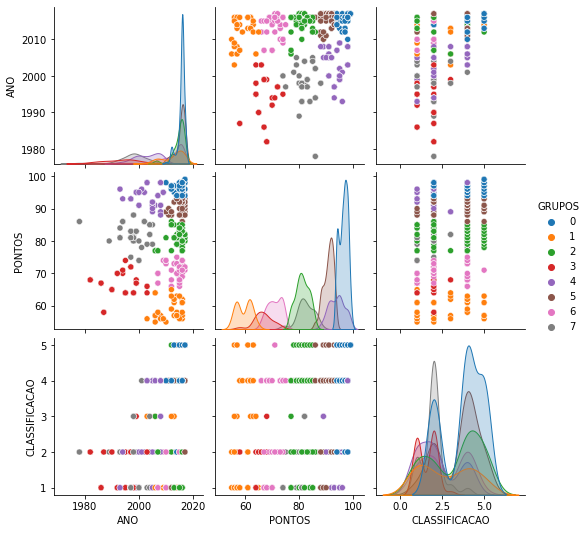

In [ ]:
# Predição K-means - CPU

Ta1 = time.time_ns()
df_cpuKM = pd.read_csv('/content/drive/My Drive/BDIA-PUCGO/Projeto_Integrador_4A/Netflix-BDIA-FINAL.csv', sep=';', 
                 encoding='utf-8', names=['CODIGO','ANO','PONTOS','CLASSIFICACAO'])
X_cpuKM = df_cpuKM.drop(columns = ['CODIGO'])

print('======== CORRELAÇÃO ========')
cor = X_cpuKM.corr()
print(cor)
print('============================')
Tb1 = time.time_ns()

Taa1 = time.time_ns()
modelo_cpuKM = KMeans(n_clusters=8, random_state=42)
modelo_cpuKM.fit(X_cpuKM)
X_cpuKM['GRUPOS'] = modelo_cpuKM.labels_
Tbb1 = time.time_ns()

Tempo1KM = Tb1-Ta1
Tempo2KM = Tbb1-Taa1

print('======= RESULTADOS =======')
print(' ==> Tempo para ajuste dos dados CPU = ', Tempo1KM/1000000, 'ms')
print(' ==> Tempo para predição do K-Means na CPU = ', Tempo2KM/1000000, 'ms')
print('======= GRAFICO =======')

sb.pairplot(X_cpuKM, hue='GRUPOS', palette='tab10');



======== CORRELAÇÃO ========
                    ANO    PONTOS  CLASSIFICACAO    GRUPOS
ANO            1.000000  0.237613       0.511639 -0.411181
PONTOS         0.237613  1.000000       0.272890 -0.196399
CLASSIFICACAO  0.511639  0.272890       1.000000 -0.286887
GRUPOS        -0.411181 -0.196399      -0.286887  1.000000
======= RESULTADOS =======
 ==> Tempo para ajuste dos dados GPU =  10.612765 ms
 ==> Tempo para predição do K-Means na GPU =  10.103294 ms
======= GRAFICO =======


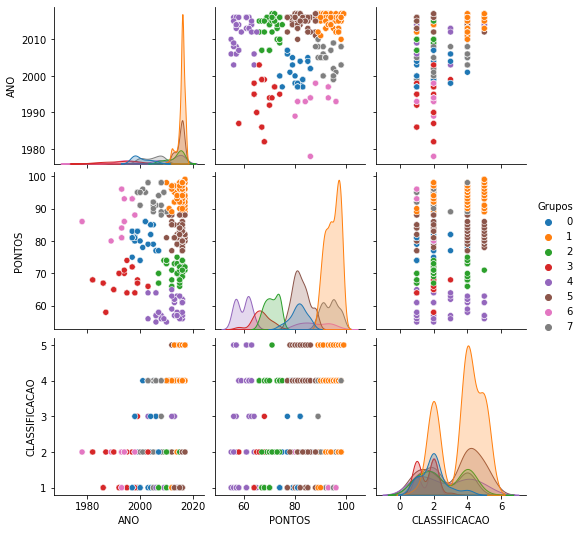

In [ ]:
# Predição K-means - GPU

Ta2 = time.time_ns()
df_gpuKM = cudf.read_csv('/content/drive/My Drive/BDIA-PUCGO/Projeto_Integrador_4A/Netflix-BDIA-FINAL.csv', sep=';', 
                       low_memory=False, encoding='utf-8', names=['CODIGO','ANO','PONTOS','CLASSIFICACAO'], dtype=float)

X_gpuKM = cudf.DataFrame()
X_gpuKM['ANO'] = df_gpuKM['ANO']
X_gpuKM['PONTOS'] = df_gpuKM['PONTOS']
X_gpuKM['CLASSIFICACAO'] = df_gpuKM['CLASSIFICACAO']

print('======== CORRELAÇÃO ========')
cor = X_cpuKM.corr()
print(cor)
print('============================')
Tb2 = time.time_ns()

Taa2 = time.time_ns()
modelo_gpuKM = KMeans_GPU(n_clusters=8, random_state=42)
modelo_gpuKM.fit(X_gpuKM)
X_gpuKM['Grupos'] = modelo_gpuKM.labels_
Tbb2 = time.time_ns()

Tempo1KMGPU = Tb2-Ta2
Tempo2KMGPU = Tbb2-Taa2

print('======= RESULTADOS =======')
print(' ==> Tempo para ajuste dos dados GPU = ', Tempo1KMGPU/1000000, 'ms')
print(' ==> Tempo para predição do K-Means na GPU = ', Tempo2KMGPU/1000000, 'ms')
print('======= GRAFICO =======')


sb.pairplot(X_gpuKM.to_pandas(), hue='Grupos', palette='tab10');
